In [4]:
!pip install tushare
!pip install tqdm
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import glob
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 5.3 MB/s eta 0:00:00
Mounted at /content/drive


In [1]:
def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_median(df, window=10):
    return df.rolling(window).median()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1


In [2]:

class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap']
        self.volume = daily_info['volume']
        self.amount = daily_info['amount']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close

        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)

        alpha_dict['alpha_w_005'] = (rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
        alpha_dict['alpha_pe']= -1*daily_info['pe_ttm']
        alpha_dict['alpha_total_mv']= daily_info['total_mv']
        alpha_dict['alpha_pb']= -1*daily_info['pb']
        alpha_dict['alpha_turnover_rate']= daily_info['turnover_rate']
        alpha_dict['alpha_volume_ratio']= daily_info['volume_ratio']
        alpha_dict['alpha_vwap']= daily_info['vwap']
        alpha_dict['alpha_dv_ttm']= -1*daily_info['dv_ttm']
        return alpha_dict


In [5]:
sp_price = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/sp300_price.csv')
sp_price.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08


In [7]:
print(sp_price.shape)
print(sp_price.shape)

(75000, 9)
(75000, 9)


In [11]:
sp_basic = pd.read_csv('/content/drive/MyDrive/alpha_python_202505/alpha_python_202505/data/sp300_basic.csv')
sp_basic.rename(columns={'ticker':'Ticker'}, inplace=True)
sp_basic.rename(columns={'trade_date':'Date'}, inplace=True)

In [12]:
sp_basic.head()

,Ticker,Date,turnover_rate,turnover_rate_f,volume_ratio,pe,pe_ttm,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,FOXA,2025-05-27,0.009493,NaN,0.743305,13.609756,13.609756,2.181221,1.469167,1.469167,0.98,0.98,214036992,343207050,NaN,23660929024,1.915095e+10
1,PARA,2025-05-27,0.007137,NaN,0.514671,NaN,NaN,0.490280,0.296184,0.296184,1.67,1.67,633454976,606229631,NaN,8506413056,7.292942e+09
2,FOX,2025-05-27,0.002710,NaN,0.714726,12.475611,12.475611,1.999453,1.469169,1.469169,1.07,1.07,235580992,343207050,NaN,23660967936,1.755504e+10
3,OMC,2025-05-27,0.010017,NaN,0.553675,9.993271,9.993271,3.312662,0.923276,0.923276,3.83,3.83,195834000,192867603,NaN,14540674048,1.432042e+10
4,T,2025-05-27,0.004640,NaN,0.808375,16.803680,16.803680,1.899709,1.604953,1.604953,4.05,4.05,7200739840,7180995106,NaN,197303320576,1.966875e+11


In [13]:
price_PD_total = pd.merge(sp_price, sp_basic,how='left', on=['Ticker','Date'])
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,pb,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
price_PD_total.columns

Index(['Date', 'Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Amount', 'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe',
       'pe_ttm', 'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv'],
      dtype='object')

In [16]:
# at the beginning of the market, the opening increases
price_PD_total['open_up'] = price_PD_total.groupby('Ticker').Open.shift(1)/price_PD_total.groupby('Ticker').Close.shift(0)
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,ps,ps_ttm,dv_ratio,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv,open_up
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.036706
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.116573
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.960816
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996956


In [18]:
#t close buy, t+1 close sell
price_PD_total['ret1'] = price_PD_total.groupby('Ticker').Close.shift(-1)/price_PD_total.groupby('Ticker').Close.shift(0)

#t+1 open buy, t+2 close sell
price_PD_total['ret2'] = price_PD_total.groupby('Ticker').Close.shift(-2)/price_PD_total.groupby('Ticker').Open.shift(-1)

# price_PD_total['ret'] = price_PD_total['ret1'] + price_PD_total['ret2']
price_PD_total['ret'] = price_PD_total['ret2'].copy()
price_PD_total.head()

,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Amount,turnover_rate,...,dv_ttm,total_share,float_share,free_share,total_mv,circ_mv,open_up,ret1,ret2,ret
0,2024-05-28,A,147.115265,148.210007,151.190002,147.699997,150.820007,1366900,2.010919e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981580,0.895598,0.895598
1,2024-05-29,A,144.405426,145.479996,146.990005,144.750000,146.740005,1603200,2.315108e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.036706,0.903354,1.040782,1.040782
2,2024-05-30,A,130.449280,131.419998,135.179993,125.300003,125.300003,5138500,6.703136e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.116573,0.992315,1.003053,1.003053
3,2024-05-31,A,129.446762,130.410004,134.070007,129.559998,131.000000,5333100,6.903525e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.960816,1.007591,1.006539,1.006539
4,2024-06-03,A,130.429428,131.399994,132.580002,130.000000,130.000000,3114800,4.062616e+08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.996956,0.995814,1.017677,1.017677


In [20]:
# len(price_PD_total.turnover_rate.unique())
price_PD_total.columns

Index(['Date', 'Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Amount', 'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe',
       'pe_ttm', 'pb', 'ps', 'ps_ttm', 'dv_ratio', 'dv_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'open_up', 'ret1',
       'ret2', 'ret'],
      dtype='object')

In [23]:
daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Open')
daily_info['high'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='High')
daily_info['low'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Low')
daily_info['close'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Close')
daily_info['volume'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Volume')
daily_info['amount'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='Amount')
daily_info['vwap'] = (daily_info['volume']*1000)/(daily_info['amount']*100+1)
daily_info['pe_ttm'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='pe_ttm')
daily_info['total_mv'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='total_mv')
daily_info['pb'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='pb')
daily_info['turnover_rate'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='turnover_rate')
daily_info['volume_ratio'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='volume_ratio')
daily_info['dv_ttm'] = pd.pivot(price_PD_total, index='Date', columns='Ticker', values='dv_ttm')



In [24]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [26]:
# alpha_dict.items()

In [27]:
data = pd.DataFrame()
for k, v in tqdm(alpha_dict.items()):
    tmp = v.unstack().reset_index().rename(columns={0:k})
    if len(data) == 0:
        data = tmp
    else:
        data = pd.merge(data, tmp, how='left', on=['Ticker','Date'])

100%|██████████| 32/32 [00:03<00:00,  8.28it/s]


In [28]:
data = pd.merge(data, price_PD_total[['Date','Ticker','ret1','ret2','ret','open_up']], how='left', on=['Ticker','Date'])

In [34]:
data.Date

,Date
0,2024-05-28
1,2024-05-29
2,2024-05-30
3,2024-05-31
4,2024-06-03
...,...
74995,2025-05-20
74996,2025-05-21
74997,2025-05-22
74998,2025-05-23


In [35]:
train = data.copy()
train = train[train.Date < '2025-02-27']

train['ret_rank'] = train.groupby('Date').ret.rank(pct=True)
train = train[~train.ret_rank.isna()].reset_index(drop=True)

from sklearn.model_selection import train_test_split, KFold, GroupKFold

kfold = KFold(n_splits=19, shuffle=True, random_state=74)

enumsplit = []
for fold, (trn_ind, val_ind) in  enumerate(kfold.split(train)):
    enumsplit.append([trn_ind, val_ind])

enumsplit

[[array([    0,     1,     2, ..., 56396, 56397, 56398]),
  array([    3,     7,    89, ..., 56377, 56381, 56399])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   35,    36,    64, ..., 56383, 56391, 56395])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   24,    29,    56, ..., 56363, 56366, 56393])],
 [array([    0,     1,     2, ..., 56396, 56397, 56399]),
  array([    6,    12,    54, ..., 56382, 56390, 56398])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   11,    21,    41, ..., 56346, 56364, 56370])],
 [array([    1,     2,     3, ..., 56397, 56398, 56399]),
  array([    0,     4,    10, ..., 56338, 56355, 56375])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   28,    48,    52, ..., 56318, 56327, 56353])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  array([   25,    49,    53, ..., 56368, 56385, 56392])],
 [array([    0,     1,     2, ..., 56397, 56398, 56399]),
  arra

In [36]:
features = ['alpha01', 'alpha02', 'alpha06', 'alpha07',
       'alpha08', 'alpha09', 'alpha10', 'alpha12', 'alpha13', 'alpha14',
       'alpha15', 'alpha16', 'alpha17', 'alpha18', 'alpha19', 'alpha20',
       'alpha21', 'alpha23', 'alpha24', 'alpha28', 'alpha29', 'alpha30',
       'alpha31', 'alpha32', 'alpha_w_005', 'alpha_pe', 'alpha_total_mv',
       'alpha_pb', 'alpha_turnover_rate', 'alpha_volume_ratio', 'alpha_vwap',
       'alpha_dv_ttm']


In [38]:
train

,Ticker,Date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_pb,alpha_turnover_rate,alpha_volume_ratio,alpha_vwap,alpha_dv_ttm,ret1,ret2,ret,open_up,ret_rank
0,A,2024-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.067974,NaN,0.981580,0.895598,0.895598,NaN,0.006667
1,A,2024-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.069249,NaN,0.903354,1.040782,1.040782,1.036706,0.910000
2,A,2024-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.076658,NaN,0.992315,1.003053,1.003053,1.116573,0.380000
3,A,2024-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.077252,NaN,1.007591,1.006539,1.006539,0.960816,0.696667
4,A,2024-06-03,NaN,0.003076,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.076670,NaN,0.995814,1.017677,1.017677,0.996956,0.796667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56395,ZTS,2025-02-20,-0.000198,0.006391,-0.000270,0.000070,-0.000896,0.000204,0.000158,0.001718,...,NaN,NaN,NaN,0.063739,NaN,1.019311,1.047725,1.047725,0.994410,0.976667
56396,ZTS,2025-02-21,-0.000057,0.003603,-0.000134,0.000054,-0.000689,0.000157,0.000122,0.001320,...,NaN,NaN,NaN,0.062531,NaN,1.030226,1.039795,1.039795,0.976193,0.930000
56397,ZTS,2025-02-24,0.000025,0.003322,-0.000048,0.000058,-0.000742,0.000169,0.000162,0.001422,...,NaN,NaN,NaN,0.060697,NaN,1.019479,0.994515,0.994515,0.954449,0.503333
56398,ZTS,2025-02-25,0.000082,0.002500,0.000028,0.000049,-0.000631,0.000208,0.000208,0.001209,...,NaN,NaN,NaN,0.059537,NaN,0.978995,0.980798,0.980798,0.961728,0.316667


**LGB Model Test**

In [42]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

modellist = []
y = train['ret_rank']
oof_preds = np.zeros(train.shape[0])

for fold, (trn_ind, val_ind) in  enumerate(enumsplit):
  print(f"Training fold {fold + 1}")
  x_train, x_val = train.iloc[trn_ind],train.iloc[val_ind]
  y_train, y_val = y.iloc[trn_ind],y.iloc[val_ind]
  train_dataset = lgb.Dataset(x_train[features], y_train)
  val_dataset = lgb.Dataset(x_val[features], y_val)
  model = lgb.LGBMRegressor()
  model.fit(x_train[features],y_train)
  modellist.append(model)
  oof_preds[val_ind] = model.predict(x_val[features])
  mse = mean_squared_error(y_val, oof_preds[val_ind])
  print(f"MSE: {mse}")
  print(f"RMSE: {mse**0.5}")
  corr_score = np.corrcoef([y_val, oof_preds[val_ind]])[0][1]
  print(f"Correlation: {corr_score}")

rmspe_score = mean_squared_error(y,oof_preds)**0.5
print(f"out of fold RMSPE: {rmspe_score}")
corr_score = np.corrcoef(y,oof_preds)[0][1]
print(f"out of fold Correlation: {corr_score}")

Training fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 53431, number of used features: 26
[LightGBM] [Info] Start training from score 0.501811
MSE: 0.07904218890343044
RMSE: 0.2811444271249751
Correlation: 0.16305527701119846
Training fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6626
[LightGBM] [Info] Number of data points in the train set: 53431, number of used features: 26
[LightGBM] [Info] Start training from score 0.502025
MSE: 0.08238258615916971
RMSE: 0.2870236682909089
Correlation: 0.12917404057497334
Training fold 3
[LightGBM] [Info] Auto-choosing col-wi

In [43]:
len(enumsplit)

19

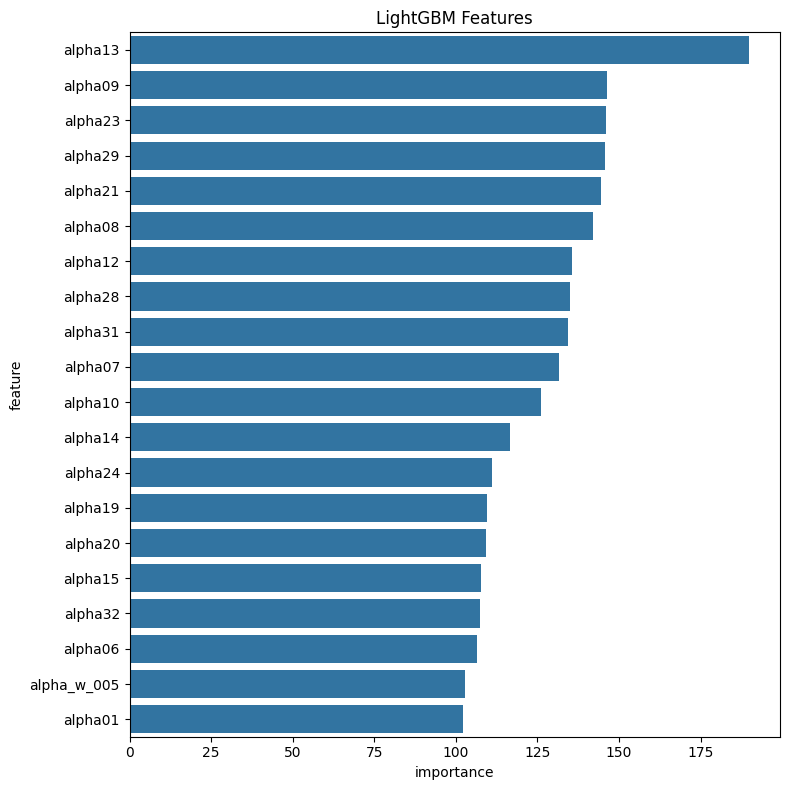

In [46]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    try:
        importances = list(model.feature_importances_)
    except:
        importances = list(model.feature_importance())
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    #print(feature_importances)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in modellist:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature",
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [48]:

test = data.copy()
test = test[test.Date > '2025-02-27']
pred = np.zeros(test.shape[0])
for model in modellist:
    pred += model.predict(test[features])
test['pred'] = pred
date_calc = sorted(test.Date.unique())



In [49]:

test['factor_rank'] = test.groupby(['Date']).pred.rank(pct=True,method='dense')


In [50]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)

test['factor_rank_bin'] = test.factor_rank.apply(fun)

In [51]:
test.factor_rank_bin.value_counts()

,count
factor_rank_bin,
10,1891
6,1830
5,1830
9,1830
8,1830
7,1830
3,1830
2,1830
4,1830


<Axes: xlabel='Date'>

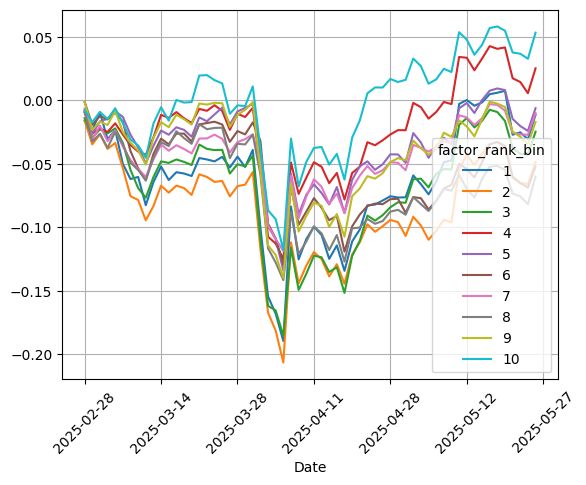

In [53]:
(test.groupby(['factor_rank_bin', \
        'Date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45,grid=True)

<Axes: xlabel='Date'>

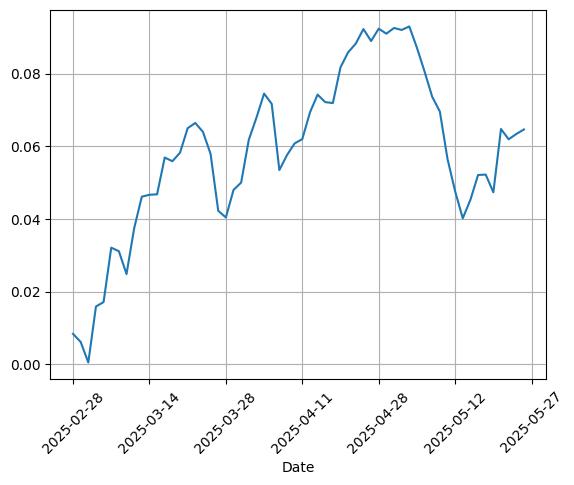

In [55]:
long_ret = (test[(test.factor_rank_bin == 10)].groupby('Date').ret1.mean()-1).cumsum()
short_ret = (test[(test.factor_rank_bin == 1)].groupby('Date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45,grid=True)

In [57]:
ret_PD = (test.groupby(['factor_rank_bin', 'Date']).ret1.mean()-1.00).unstack().T

if ret_PD[1].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1]


In [58]:

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end





def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,-0.047450,-0.131367,0.022753,0.540984,-0.181659
1,2,-0.204305,-0.619793,0.020765,0.459016,-0.193567
2,3,-0.103616,-0.345216,0.018907,0.459016,-0.173891
3,4,0.105966,0.373969,0.017850,0.442623,-0.121837
4,5,-0.025932,-0.090833,0.017985,0.491803,-0.131591
5,6,-0.218619,-0.837668,0.016441,0.491803,-0.127774
6,7,-0.042207,-0.176615,0.015054,0.442623,-0.112853
7,8,-0.251733,-0.982109,0.016147,0.459016,-0.134297
8,9,-0.071210,-0.240541,0.018649,0.442623,-0.138964
9,10,0.223958,0.707117,0.019951,0.475410,-0.135044


<ipython-input-59-299a8f4b0a98>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp = tmp.groupby('Date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)


<Axes: title={'center': '2024-2025 year'}, xlabel='Date'>

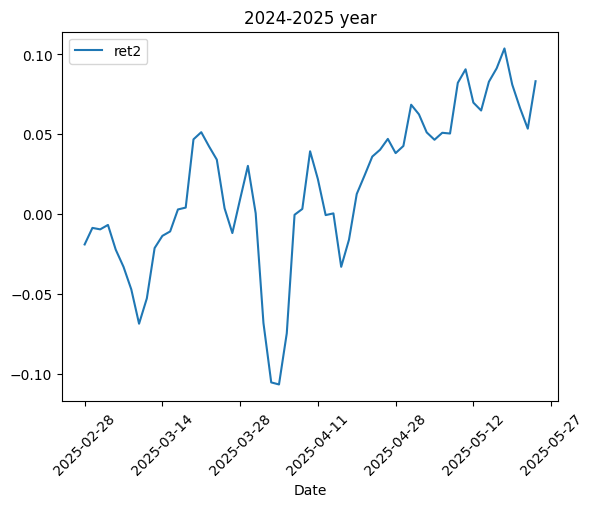

In [59]:
tmp = test.copy()
tmp = tmp[(tmp.open_up<1.05)&(tmp.open_up>0.95)]
num = 10
tmp = tmp.groupby('Date').apply(lambda x: x.sort_values('pred', ascending = False).head(num)).reset_index(drop=True)
ret_pd1 = pd.DataFrame(tmp.groupby('Date').ret2.mean() - 1.0005)
(ret_pd1.loc['2024-05-08':,] ).cumsum().plot(rot=45, title = '2024-2025 year')

In [62]:
def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min().values[0]
    end = returns.index[dd.values.argmin()]
    start = returns.index[r.loc[:end].values.argmax()]
    return mdd, start, end


def calc_pfmc(ret_PD):
    ret_PD_ = ret_PD.copy()
    performance = []
    ret_PD_.columns = ['ret']
    returnlist = ret_PD_['ret']
    ret_year = (returnlist.mean())*252
    ret_sharpe = (returnlist.mean())/returnlist.std()*((252)**0.5)

    winratio = (returnlist>0).sum()/(returnlist!=0).sum()
    std = returnlist.std()

    ret2_len = pd.DataFrame(tmp.groupby('Date').ret.count())
    ret2_len = ret2_len.reindex(date_calc).fillna(0)
    stock_pct = ret2_len.mean().values[0]
    max_draw, start, end = max_dd(ret_PD)
    performance.append(['LGB',ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])



    return performance

In [63]:
calc_pfmc(ret_pd1)

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.355328,0.98618,0.022697,0.52459,-0.150012


In [69]:
tmp[tmp.Date=='2025-02-28'][['Ticker','Date','pred','ret','ret1','ret2']].head(10)

,Ticker,Date,pred,ret,ret1,ret2
0,UNH,2025-02-28,11.128566,1.000506,0.983346,1.000506
1,BKNG,2025-02-28,10.863421,0.976553,0.986073,0.976553
2,VTRS,2025-02-28,10.626756,1.008611,1.010834,1.008611
3,ORLY,2025-02-28,10.611906,0.981637,1.001711,0.981637
4,BRK-B,2025-02-28,10.564221,0.960559,0.992702,0.960559
5,MHK,2025-02-28,10.555355,0.964569,0.989030,0.964569
6,SNA,2025-02-28,10.538412,0.962373,0.979218,0.962373
7,V,2025-02-28,10.357050,0.970331,0.997546,0.970331
8,ELV,2025-02-28,10.337008,0.993175,0.996523,0.993175
9,LLY,2025-02-28,10.331444,0.998094,1.009874,0.998094


In [68]:
tmp

,Ticker,Date,alpha01,alpha02,alpha06,alpha07,alpha08,alpha09,alpha10,alpha12,...,alpha_volume_ratio,alpha_vwap,alpha_dv_ttm,ret1,ret2,ret,open_up,pred,factor_rank,factor_rank_bin
0,UNH,2025-02-28,-0.000213,0.011156,-0.000207,-0.000029,-0.008289,0.001519,0.000322,0.009230,...,NaN,0.021144,NaN,0.983346,1.000506,1.000506,0.981493,11.128566,1.000000,10
1,BKNG,2025-02-28,-0.000023,0.005639,-0.000016,0.000332,-0.000801,0.002052,0.000925,0.002047,...,NaN,0.001998,NaN,0.986073,0.976553,0.976553,1.005203,10.863421,0.993333,10
2,VTRS,2025-02-28,-0.000144,0.000760,-0.000067,0.000018,-0.000465,0.000278,0.000030,0.000599,...,NaN,1.112776,NaN,1.010834,1.008611,1.008611,1.003250,10.626756,0.990000,10
3,ORLY,2025-02-28,0.000071,0.001918,0.000031,0.000072,-0.000072,0.000386,0.000196,0.000405,...,NaN,0.007280,NaN,1.001711,0.981637,0.981637,0.971870,10.611906,0.986667,10
4,BRK-B,2025-02-28,0.000607,0.012033,0.000263,0.000837,-0.000077,0.002354,0.001417,0.002711,...,NaN,0.019462,NaN,0.992702,0.960559,0.960559,0.966176,10.564221,0.983333,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,COF,2025-05-27,-0.000062,0.005354,-0.000089,0.000683,-0.000463,0.005311,0.003327,0.007332,...,1.238213,0.052070,-1.30,NaN,NaN,NaN,0.955845,10.647226,0.983333,10
606,ERIE,2025-05-27,-0.000005,0.000217,-0.000005,0.000008,-0.000058,0.000047,0.000016,0.000142,...,1.109048,0.028296,-1.57,NaN,NaN,NaN,0.976232,10.525846,0.976667,10
607,NDSN,2025-05-27,-0.000003,0.000269,-0.000004,0.000027,-0.000030,0.000086,0.000060,0.000157,...,0.975085,0.050503,-1.58,NaN,NaN,NaN,0.972830,10.427288,0.973333,10
608,META,2025-05-27,0.000021,0.026994,-0.000105,0.008301,-0.004909,0.021455,0.021455,0.027390,...,0.530418,0.015569,-0.33,NaN,NaN,NaN,0.971478,10.386741,0.970000,10


In [142]:
import yfinance as yf

dfindex = yf.download(tickers='^SPX', start='2025-02-28',end='2025-05-27')

[*********************100%***********************]  1 of 1 completed


In [143]:
dfindex.columns

MultiIndex([( 'Close', '^SPX'),
            (  'High', '^SPX'),
            (   'Low', '^SPX'),
            (  'Open', '^SPX'),
            ('Volume', '^SPX')],
           names=['Price', 'Ticker'])

In [144]:
dfindex['ret'] = dfindex[('Close', '^SPX')].pct_change()
dfindex

Price,Close,High,Low,Open,Volume,ret
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX,
Date,,,,,,
2025-02-28,5954.500000,5959.399902,5837.660156,5856.740234,6441140000,NaN
2025-03-03,5849.720215,5986.089844,5810.910156,5968.330078,5613850000,-0.017597
2025-03-04,5778.149902,5865.080078,5732.589844,5811.979980,6138110000,-0.012235
2025-03-05,5842.629883,5860.589844,5742.350098,5781.359863,5285970000,0.011159
2025-03-06,5738.520020,5812.080078,5711.640137,5785.870117,5165080000,-0.017819
2025-03-07,5770.200195,5783.009766,5666.290039,5726.009766,5705140000,0.005521
2025-03-10,5614.560059,5705.370117,5564.020020,5705.370117,6409370000,-0.026973
2025-03-11,5572.069824,5636.299805,5528.410156,5603.649902,6221240000,-0.007568


In [145]:
# Calculate pct_change for ('Close', '^SPX')
pct_chg = dfindex[('Close', '^SPX')].pct_change()

# Create DataFrame with Date as a column and pct_chg as another
result = pct_chg.rename('pct_chg').reset_index()
result.columns = ['Date', 'pct_chg']  # Ensure column names are as desired

dfindex = result.set_index('Date')
# dfindex


In [128]:
ret_pd1.head(10)

,ret2
Date,
2025-02-28,-0.018859
2025-03-03,0.010351
2025-03-04,-0.000910
2025-03-05,0.002765
2025-03-06,-0.015468
2025-03-07,-0.010728
2025-03-10,-0.014102
2025-03-11,-0.021459
2025-03-12,0.015849


In [129]:
dfindex.head(10)

,pct_chg
Date,
2025-02-28,NaN
2025-03-03,-0.017597
2025-03-04,-0.012235
2025-03-05,0.011159
2025-03-06,-0.017819
2025-03-07,0.005521
2025-03-10,-0.026973
2025-03-11,-0.007568
2025-03-12,0.004887


In [135]:
# print(ret_pd1.index)
# print(dfindex.index)
# print(ret_pd1.index.dtype)
# print(dfindex.index.dtype)
# For ret_pd1 (object/string index)
ret_pd1.index = pd.to_datetime(ret_pd1.index)

# For dfindex (optional, if already DatetimeIndex, but safe)
dfindex.index = pd.to_datetime(dfindex.index)


In [136]:
# ret_pd_concat = pd.concat([ret_pd1, dfindex], axis=1)
ret_pd_concat = pd.merge(ret_pd1,dfindex,left_index=True, right_index=True)
ret_pd_concat

,ret2,pct_chg
Date,,
2025-02-28,-0.018859,NaN
2025-03-03,0.010351,-0.017597
2025-03-04,-0.000910,-0.012235
2025-03-05,0.002765,0.011159
2025-03-06,-0.015468,-0.017819
2025-03-07,-0.010728,0.005521
2025-03-10,-0.014102,-0.026973
2025-03-11,-0.021459,-0.007568
2025-03-12,0.015849,0.004887


In [137]:
# ret_pd_concat = pd.merge(ret_pd1,dfindex*100,left_index=True, right_index=True)
ret_pd_concat = pd.concat([ret_pd1, dfindex], axis=1)
ret_pd_concat.columns = ['ret','dfindex']
ret_pd_concat['diff'] = ret_pd_concat['ret'] - ret_pd_concat['dfindex']
ret_pd_concat

,ret,dfindex,diff
Date,,,
2025-02-28,-0.018859,NaN,NaN
2025-03-03,0.010351,-0.017597,0.027948
2025-03-04,-0.000910,-0.012235,0.011325
2025-03-05,0.002765,0.011159,-0.008394
2025-03-06,-0.015468,-0.017819,0.002351
...,...,...,...
2025-05-20,-0.014624,-0.003880,-0.010743
2025-05-21,-0.012941,-0.016135,0.003194
2025-05-22,0.029662,-0.000445,0.030107


In [138]:
ret_pd_concat.corr()

,ret,dfindex,diff
ret,1.000000,-0.028943,0.746171
dfindex,-0.028943,1.000000,-0.687072
diff,0.746171,-0.687072,1.000000


<Axes: title={'center': '2022-2024 year'}, xlabel='Date'>

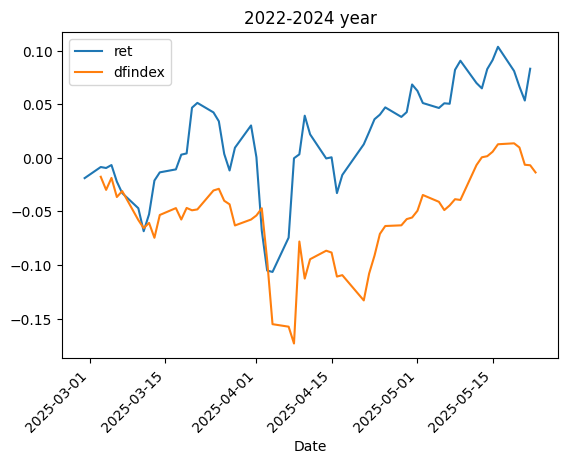

In [139]:
(ret_pd_concat[['ret','dfindex']].cumsum()).plot(rot=45, title = '2022-2024 year')


In [140]:
ret_pd1.columns

Index(['ret2'], dtype='object')

In [141]:
calc_pfmc(ret_pd_concat[['diff']])

,group_name,return,sharpe,std,winratio,mdd
0,LGB,0.47315,0.952969,0.031277,0.47541,-0.107629
